/Users/cherylwang/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


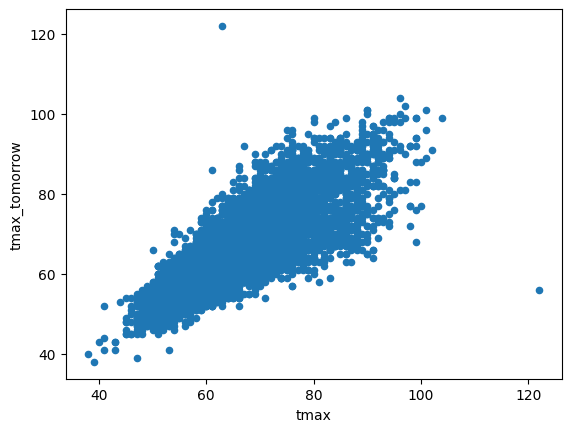

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statistics import mean

# read the CSV file "clean_weather.csv" into a DataFrame.
# set the first column (usually the date or unnamed index) as the DataFrame index.
data = pd.read_csv("clean_weather.csv", index_col=0)

# forward-fill missing values (NaNs) in the DataFrame using the last known non-missing value.
# this is useful in time series data where missing values can be inferred from prior entries.
data = data.ffill()

# create a scatter plot to visualize the relationship between today's maximum temperature (tmax)
# and tomorrow's maximum temperature (tmax_tomorrow). This helps assess if a linear trend exists.
data.plot.scatter("tmax", "tmax_tomorrow")

PREDICTORS = ['tmax', 'tmin', 'rain']
TARGET = 'tmax_tomorrow'

# all values are scaled so mean is 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

split_data = np.split(data, [int(0.7*len(data)), int(0.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

### NEURAL NETWORK


In [12]:
def init_layers(inputs):
    layers = []
    for i in range(1, len(inputs)):
        layers.append([
            np.random.rand(inputs[i-1], inputs[i]) / 5 - .1,
            np.ones((1, inputs[i]))
        ])
    return layers

# second layer calculates 10 features from 3, etc, and output one
layer_conf = [3, 10, 10, 1]
layers = init_layers(layer_conf)

In [ ]:
layers

In [14]:
def forward(batch, layers): 
    hiddens = [batch.copy()]
    for i in range(len(layers)):
        # batch = xw + b
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        # dont apply relu on last layer
        if i < len(layers) - 1:
            batch = np.maximum(batch, 0)
        hiddens.append(batch.copy())
    return batch, hiddens


In [15]:
# define a function to calculate mean squared error
def mse(actual, predicted):
    # subtract the predicted values from the actual values, square the differences,
    # then take the mean of all squared differences
    return np.mean((actual - predicted) ** 2)

def mse_grad(actual, predicted):
    return predicted - actual

In [16]:
def backward(layers, hidden, grad, lr):
    for i in range(len(layers)-1, -1, -1):
        # if not at last layer, redo relu function
        if i != len(layers) - 1:
            grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

        w_grad = hidden[i].T @ grad
        b_grad = np.mean(grad, axis=0)

        # update weights
        layers[i][0] -= w_grad * lr
        layers[i][1] -= b_grad * lr

        grad = grad @ layers[i][0].T
    return layers


### TRAINING ALGORITHM ###
1. run network forward pass to get output
2. compute gradient with respect to ouptus of the network (`mse_grad` function)
3. for each layer in the network:
    - compute the gradient with respect to the pre-nonlinearity ouptu (if the layer has a onlinearity)
    - compute the gradient with respect to the weights
    - compute the gradient with respect to the bias
    - compute the gradient with respect to the inputs to the layer
4. update the parameters in the network using gradient descent

In [24]:
lr = 1e-6

epochs = 10
batch_size = 8

layers = init_layers(layer_conf)

for epoch in range(epochs):
    epoch_loss = []

    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i+batch_size)]
        y_batch = train_y[i:(i+batch_size)]

        pred, hidden = forward(x_batch, layers)

        loss = mse_grad(y_batch, pred)
        epoch_loss.append(np.mean(loss**2))

        layers = backward(layers, hidden, loss, lr)
    
    valid_preds, _ = forward(valid_x, layers)
    print(f"Epoch {epoch} Train mse: {mean(epoch_loss)} valid mse: {np.mean(mse(valid_preds, valid_y))}")
    

Epoch 0 Train mse: 3341.9141181967807 valid mse: 1792.0115596606813
Epoch 1 Train mse: 374.0394614427606 valid mse: 27.089105080917964
Epoch 2 Train mse: 23.71512510810377 valid mse: 21.47403807798439
Epoch 3 Train mse: 22.541568764602648 valid mse: 20.901293346926934
Epoch 4 Train mse: 22.216237289794762 valid mse: 20.783700835378525
Epoch 5 Train mse: 22.133430512425488 valid mse: 20.765327232889632
Epoch 6 Train mse: 22.11092817069329 valid mse: 20.766231231853308
Epoch 7 Train mse: 22.103505536136552 valid mse: 20.768957460319836
Epoch 8 Train mse: 22.100098405817892 valid mse: 20.77121536303786
Epoch 9 Train mse: 22.097683044573824 valid mse: 20.772442377594917
